# Example of a full processing workflow for Slocum glider AD2CP data

## Imports

In [1]:
# Imports
import numpy as np
import pandas as pd
import glob
import datetime
import xarray as xr
import gsw
import matplotlib.pyplot as plt
from datetime import datetime
import dask.array as da
import slocum_ad2cp


## Step 1: Load Glider Data

In [2]:
ds_id = 'ru29-20240419T1430-trajectory-raw-delayed'

## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time','source_file', 'm_water_vx', 'm_water_vy', 'm_heading','m_gps_mag_var']
gdf = slocum_ad2cp.get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
gdf.columns = variables

## Great way to find start and end times!!
start_times = gdf.groupby('source_file').first().time.values
end_times   = gdf.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)
gdf['time'] = pd.to_datetime(gdf.time)
## Convert magnetic variation and heading to degrees
gdf['m_gps_mag_var'] = np.rad2deg(gdf['m_gps_mag_var'].values)
gdf['m_heading'] = np.rad2deg(gdf['m_heading'].values)
## Correct heading for magnetic variation
gdf['m_heading'] = gdf.m_heading-np.nanmean(gdf.m_gps_mag_var)

gdf

,depth,latitude,longitude,time,source_file,m_water_vx,m_water_vy,m_heading,m_gps_mag_var
0,0.000000,17.779262,-67.057948,2024-04-19 14:30:28+00:00,ru29-2024-109-2-0-dbd(06930000),NaN,NaN,NaN,NaN
1,NaN,17.779262,-67.057948,2024-04-19 14:30:31+00:00,ru29-2024-109-2-0-dbd(06930000),0.0,0.0,130.305985,12.40001
2,0.000000,17.779262,-67.057948,2024-04-19 14:30:32+00:00,ru29-2024-109-2-0-dbd(06930000),NaN,NaN,NaN,NaN
3,NaN,17.779262,-67.057948,2024-04-19 14:31:29+00:00,ru29-2024-109-2-0-dbd(06930000),0.0,0.0,130.305985,12.40001
4,NaN,17.779350,-67.057945,2024-04-19 14:31:49+00:00,ru29-2024-109-2-0-dbd(06930000),NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
7446400,0.099413,15.649022,-68.998793,2024-07-02 09:09:13+00:00,ru29-2024-182-1-9-dbd(07060009),NaN,NaN,NaN,NaN
7446401,0.089471,15.649022,-68.998793,2024-07-02 09:09:15+00:00,ru29-2024-182-1-9-dbd(07060009),NaN,NaN,NaN,NaN
7446402,-0.049706,15.649022,-68.998793,2024-07-02 09:09:17+00:00,ru29-2024-182-1-9-dbd(07060009),NaN,NaN,NaN,NaN
7446403,-0.019883,15.649022,-68.998793,2024-07-02 09:09:19+00:00,ru29-2024-182-1-9-dbd(07060009),NaN,NaN,NaN,NaN


## Step 2: Load in AD2CP data frame

To download test data (266 MB), from the main slocum_ad2cp directory do the following:<br>
1) `curl -L "https://rutgers.box.com/shared/static/597hp2xyqe4msp3xyx0t3fluueh3khtr" -o raw_data.zip` <br><br>
2) `unzip raw_data.zip`


In [3]:
path='../raw_data/'
files = np.sort(glob.glob(path+'*.nc'))
tot_ad2cp = slocum_ad2cp.load_ad2cp(files,mean_lat=15)
tot_ad2cp

/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Slocum-AD2CP/src/slocum_ad2cp/make_dataset.py:857: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(
/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Slocum-AD2CP/src/slocum_ad2cp/make_dataset.py:857: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_mfdataset(
/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Slocum-AD2CP/src/slocum_ad2cp/make_dataset.py:857: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.


<xarray.Dataset> Size: 1GB
Dimensions:                    (time: 1152490, VelocityRange: 15,
                                CorrelationRange: 15, AmplitudeRange: 15,
                                Physicalbeam_dim: 4)
Coordinates:
  * time                       (time) datetime64[ns] 9MB 2024-04-19T14:32:13....
  * VelocityRange              (VelocityRange) float32 60B 2.2 4.2 ... 28.2 30.2
  * CorrelationRange           (CorrelationRange) float32 60B 2.2 4.2 ... 30.2
  * AmplitudeRange             (AmplitudeRange) float32 60B 2.2 4.2 ... 30.2
Dimensions without coordinates: Physicalbeam_dim
Data variables: (12/43)
    VelocityBeam1              (VelocityRange, time) float32 69MB dask.array<chunksize=(15, 80990), meta=np.ndarray>
    VelocityBeam2              (VelocityRange, time) float32 69MB dask.array<chunksize=(15, 80990), meta=np.ndarray>
    VelocityBeam3              (VelocityRange, time) float32 69MB dask.array<chunksize=(15, 80990), meta=np.ndarray>
    VelocityBeam4              (VelocityRange, time) float32 69MB dask.array<chunksize=(15, 80990), meta=np.ndarray>
    CorrelationBeam1           (CorrelationRange, time) float32 69MB dask.array<chunksize=(15, 80990), meta=np.ndarray>
    CorrelationBeam2           (CorrelationRange, time) float32 69MB dask.array<chunksize=(15, 80990), meta=np.ndarray>
    ...                         ...
    EnsembleCount              (time) float64 9MB dask.array<chunksize=(80990,), meta=np.ndarray>
    WaterTemperature           (time) float32 5MB dask.array<chunksize=(80990,), meta=np.ndarray>
    Heading                    (time) float32 5MB dask.array<chunksize=(80990,), meta=np.ndarray>
    Pitch                      (time) float32 5MB dask.array<chunksize=(80990,), meta=np.ndarray>
    Roll                       (time) float32 5MB dask.array<chunksize=(80990,), meta=np.ndarray>
    Depth                      (time) float64 9MB 0.85 0.9305 ... 0.8251 0.8928
Attributes: (12/350)
    instrumentOffsetTimeMatlab_description:       Offset from instrument time...
    File_ins_runTime:                             442996000.0
    File_ins_runTime_description:                 Length of time data was col...
    File_ins_name:                                AD2CPRaw
    File_ins_name_description:                    Name of instrument
    File_ins_typeName:                            
    ...                                           ...
    instrumentOffsetTime:                         0.0
    instrumentOffsetTime_description:             Offset from instrument time...
    timeZoneOffset:                               0
    timeZoneOffset_description:                   Offset of platform local ti...
    instrumentOffsetTimeMatlab:                   0.0
    exportRevision:                               4489

## Step 3: Soft Iron Magnetic Correction (pitch-dependent)
Best to do this on the entire dataset first

In [4]:
tot_ad2cp = slocum_ad2cp.correct_ad2cp_heading(tot_ad2cp)

/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/code/GitHub/Slocum-AD2CP/src/slocum_ad2cp/make_dataset.py:963: RuntimeWarning: invalid value encountered in sqrt
  radii = np.sqrt(1. / evals)


## Steps 4-11: Big loop to process velocity data and save output

In [6]:
for x in range(0,len(start_times)):

    ## Subset glider df to one segment
    subsetgdf = gdf[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])]
    
    ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()
    
    if len(ind)>0:
        ## Pull out last non-NaN lat/lon    
        vx          = subsetgdf.m_water_vx.iloc[ind[-1]]
        vy          = subsetgdf.m_water_vy.iloc[ind[-1]]
        mag_var     = np.nanmean(subsetgdf.m_gps_mag_var) ## mean over the whole segment for this one because it only changes at the surface
        vx_start_lon = subsetgdf.longitude.iloc[ind[0]]
        vx_start_lat = subsetgdf.latitude.iloc[ind[0]]
        vx_end_lon   = subsetgdf.longitude.iloc[ind[-1]]
        vx_end_lat   = subsetgdf.latitude.iloc[ind[-1]]
        vx_start_tm = subsetgdf.time.iloc[0]
        vx_end_tm   = subsetgdf.time.iloc[-1]
        
    if subsetgdf.depth.max() < 10:
            continue
            
    ad2cp_time_ind = np.where((tot_ad2cp.time.values >= start_times2[x]) & (tot_ad2cp.time.values <= end_times2[x]))[0]
    if len(ad2cp_time_ind) > 0:

        subset_ad2cp = tot_ad2cp.sel(time= slice(tot_ad2cp.time.values[ad2cp_time_ind[0]],tot_ad2cp.time.values[ad2cp_time_ind[-1]]))

        # Just check if there is still data after the subsetting 
        if len(subset_ad2cp.time) > 0:
            
            # Pre-process data before inversion

            ## Correct DAC for local magnetic declination
            _,vx_cor,vy_cor= slocum_ad2cp.mag_var_correction(subsetgdf['m_heading'].values,vx,vy,mag_var)
            ## Correct AD2CP heading for local magnetic declination
            subset_ad2cp= slocum_ad2cp.mag_var_correction_ad2cp_ds(subset_ad2cp, heading_var="CorrectedHeading", mag_var_arr=mag_var)
            ## Correct for local speed of sound
            subset_ad2cp = slocum_ad2cp.correct_sound_speed(subset_ad2cp)
            ## QAQC pre-coordinate transformation
            subset_ad2cp = slocum_ad2cp.qaqc_pre_coord_transform(subset_ad2cp, corr_threshold = 50, max_amplitude = 75)
            ## Correct beams to level true-depth
            subset_ad2cp = slocum_ad2cp.beam_true_depth(subset_ad2cp)
            ## Bin map
            subset_ad2cp = slocum_ad2cp.binmap_adcp(subset_ad2cp)
            ## AHRS rotation matrix
            subset_ad2cp = slocum_ad2cp.calcAHRS(subset_ad2cp)
            ## Beam to ENU
            subset_ad2cp = slocum_ad2cp.beam2enu(subset_ad2cp)
            ## QAQC post-coordinate transformation
            subset_ad2cp = slocum_ad2cp.qaqc_post_coord_transform(subset_ad2cp, high_velocity_threshold=0.75, surface_depth_to_filter = 5)
            
            ## Now ready for inversion!
            dz=10            
            wDAC = 5
            wSmoothness = 1
            O_ls, G_ls, bin_new, obs_per_bin = slocum_ad2cp.inversion(subset_ad2cp.UVelocity.values,subset_ad2cp.VVelocity.values,
                                                                      dz,vx_cor,vy_cor,subset_ad2cp['VelocityRange'].values,subset_ad2cp['Depth'].values, wDAC, wSmoothness)
            now = datetime.now().strftime("%m/%d/%y %H:%M:%S")
            print("Finished Inversion", x ,"out of",len(start_times),"at" ,now)

            ###############################################
            #             Save master dataset             #
            ###############################################
            fname = "../processed_data/RU29_2024_AD2CP_Processed_Segment_"+str(x)+".csv".format(dz,x)

            ## Make into a dataframe to save as a CSV
            d = {'inversion_u': np.real(O_ls), 'inversion_v': np.imag(O_ls), "inversion_depth": bin_new,
                 "start_lon": np.tile(vx_start_lon,len(bin_new)), "start_lat": np.tile(vx_start_lat,len(bin_new)),
                 "end_lon": np.tile(vx_end_lon,len(bin_new)), "end_lat": np.tile(vx_end_lat,len(bin_new)),
                 "start_tm": np.tile(vx_start_tm, len(bin_new)), "end_tm": np.tile(vx_end_tm, len(bin_new)),
                 "obs_per_bin": obs_per_bin}


            df = pd.DataFrame(data=d)
            df.to_csv(fname,index=False) 
            now = datetime.now().strftime("%m/%d/%y %H:%M:%S")
            print("Finished Writing Data", x ,"out of",len(start_times),"at" ,now)
            del subset_ad2cp
            
        else:
            del subset_ad2cp
            

/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 0 out of 1345 at 09/17/25 14:41:18
Finished Writing Data 0 out of 1345 at 09/17/25 14:41:18


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 1 out of 1345 at 09/17/25 14:41:19
Finished Writing Data 1 out of 1345 at 09/17/25 14:41:19


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 4 out of 1345 at 09/17/25 14:41:24
Finished Writing Data 4 out of 1345 at 09/17/25 14:41:24


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 6 out of 1345 at 09/17/25 14:41:28
Finished Writing Data 6 out of 1345 at 09/17/25 14:41:28


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 8 out of 1345 at 09/17/25 14:41:33
Finished Writing Data 8 out of 1345 at 09/17/25 14:41:33


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 10 out of 1345 at 09/17/25 14:41:37
Finished Writing Data 10 out of 1345 at 09/17/25 14:41:37


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 12 out of 1345 at 09/17/25 14:41:42
Finished Writing Data 12 out of 1345 at 09/17/25 14:41:42


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 15 out of 1345 at 09/17/25 14:41:48
Finished Writing Data 15 out of 1345 at 09/17/25 14:41:48


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 17 out of 1345 at 09/17/25 14:41:53
Finished Writing Data 17 out of 1345 at 09/17/25 14:41:53


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 19 out of 1345 at 09/17/25 14:41:58
Finished Writing Data 19 out of 1345 at 09/17/25 14:41:58


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 21 out of 1345 at 09/17/25 14:42:02
Finished Writing Data 21 out of 1345 at 09/17/25 14:42:02


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 23 out of 1345 at 09/17/25 14:42:07
Finished Writing Data 23 out of 1345 at 09/17/25 14:42:07


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 24 out of 1345 at 09/17/25 14:42:10
Finished Writing Data 24 out of 1345 at 09/17/25 14:42:10


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 26 out of 1345 at 09/17/25 14:42:15
Finished Writing Data 26 out of 1345 at 09/17/25 14:42:15


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 28 out of 1345 at 09/17/25 14:42:19
Finished Writing Data 28 out of 1345 at 09/17/25 14:42:19


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 30 out of 1345 at 09/17/25 14:42:24
Finished Writing Data 30 out of 1345 at 09/17/25 14:42:24


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 32 out of 1345 at 09/17/25 14:42:29
Finished Writing Data 32 out of 1345 at 09/17/25 14:42:29


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 34 out of 1345 at 09/17/25 14:42:34
Finished Writing Data 34 out of 1345 at 09/17/25 14:42:34


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 37 out of 1345 at 09/17/25 14:42:38
Finished Writing Data 37 out of 1345 at 09/17/25 14:42:38


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 39 out of 1345 at 09/17/25 14:42:43
Finished Writing Data 39 out of 1345 at 09/17/25 14:42:43


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 41 out of 1345 at 09/17/25 14:42:48
Finished Writing Data 41 out of 1345 at 09/17/25 14:42:48


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 43 out of 1345 at 09/17/25 14:42:53
Finished Writing Data 43 out of 1345 at 09/17/25 14:42:53


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 45 out of 1345 at 09/17/25 14:42:59
Finished Writing Data 45 out of 1345 at 09/17/25 14:42:59


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 46 out of 1345 at 09/17/25 14:43:03
Finished Writing Data 46 out of 1345 at 09/17/25 14:43:03


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 48 out of 1345 at 09/17/25 14:43:08
Finished Writing Data 48 out of 1345 at 09/17/25 14:43:08


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 50 out of 1345 at 09/17/25 14:43:14
Finished Writing Data 50 out of 1345 at 09/17/25 14:43:14


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 52 out of 1345 at 09/17/25 14:43:19
Finished Writing Data 52 out of 1345 at 09/17/25 14:43:19


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 54 out of 1345 at 09/17/25 14:43:24
Finished Writing Data 54 out of 1345 at 09/17/25 14:43:24


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 56 out of 1345 at 09/17/25 14:43:30
Finished Writing Data 56 out of 1345 at 09/17/25 14:43:30


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 59 out of 1345 at 09/17/25 14:43:35
Finished Writing Data 59 out of 1345 at 09/17/25 14:43:35


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 61 out of 1345 at 09/17/25 14:43:40
Finished Writing Data 61 out of 1345 at 09/17/25 14:43:40


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 63 out of 1345 at 09/17/25 14:43:45
Finished Writing Data 63 out of 1345 at 09/17/25 14:43:45


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 65 out of 1345 at 09/17/25 14:43:50
Finished Writing Data 65 out of 1345 at 09/17/25 14:43:50


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 67 out of 1345 at 09/17/25 14:43:56
Finished Writing Data 67 out of 1345 at 09/17/25 14:43:56


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 68 out of 1345 at 09/17/25 14:44:02
Finished Writing Data 68 out of 1345 at 09/17/25 14:44:02


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 70 out of 1345 at 09/17/25 14:44:07
Finished Writing Data 70 out of 1345 at 09/17/25 14:44:07


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 72 out of 1345 at 09/17/25 14:44:12
Finished Writing Data 72 out of 1345 at 09/17/25 14:44:12


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 74 out of 1345 at 09/17/25 14:44:17
Finished Writing Data 74 out of 1345 at 09/17/25 14:44:17


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 75 out of 1345 at 09/17/25 14:44:23
Finished Writing Data 75 out of 1345 at 09/17/25 14:44:23


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 77 out of 1345 at 09/17/25 14:44:29
Finished Writing Data 77 out of 1345 at 09/17/25 14:44:29


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 78 out of 1345 at 09/17/25 14:44:35
Finished Writing Data 78 out of 1345 at 09/17/25 14:44:35


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 81 out of 1345 at 09/17/25 14:44:41
Finished Writing Data 81 out of 1345 at 09/17/25 14:44:41


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 83 out of 1345 at 09/17/25 14:44:46
Finished Writing Data 83 out of 1345 at 09/17/25 14:44:46


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 85 out of 1345 at 09/17/25 14:44:52
Finished Writing Data 85 out of 1345 at 09/17/25 14:44:52


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 87 out of 1345 at 09/17/25 14:44:58
Finished Writing Data 87 out of 1345 at 09/17/25 14:44:58


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 89 out of 1345 at 09/17/25 14:44:59
Finished Writing Data 89 out of 1345 at 09/17/25 14:44:59


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 90 out of 1345 at 09/17/25 14:45:04
Finished Writing Data 90 out of 1345 at 09/17/25 14:45:04


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 92 out of 1345 at 09/17/25 14:45:09
Finished Writing Data 92 out of 1345 at 09/17/25 14:45:09


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 94 out of 1345 at 09/17/25 14:45:14
Finished Writing Data 94 out of 1345 at 09/17/25 14:45:14


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 96 out of 1345 at 09/17/25 14:45:18
Finished Writing Data 96 out of 1345 at 09/17/25 14:45:18


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 98 out of 1345 at 09/17/25 14:45:23
Finished Writing Data 98 out of 1345 at 09/17/25 14:45:23


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 101 out of 1345 at 09/17/25 14:45:29
Finished Writing Data 101 out of 1345 at 09/17/25 14:45:29


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 103 out of 1345 at 09/17/25 14:45:35
Finished Writing Data 103 out of 1345 at 09/17/25 14:45:35


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 105 out of 1345 at 09/17/25 14:45:40
Finished Writing Data 105 out of 1345 at 09/17/25 14:45:40


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 107 out of 1345 at 09/17/25 14:45:45
Finished Writing Data 107 out of 1345 at 09/17/25 14:45:45


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 109 out of 1345 at 09/17/25 14:45:51
Finished Writing Data 109 out of 1345 at 09/17/25 14:45:51


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 112 out of 1345 at 09/17/25 14:45:56
Finished Writing Data 112 out of 1345 at 09/17/25 14:45:56


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 114 out of 1345 at 09/17/25 14:46:00
Finished Writing Data 114 out of 1345 at 09/17/25 14:46:00


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 116 out of 1345 at 09/17/25 14:46:05
Finished Writing Data 116 out of 1345 at 09/17/25 14:46:05


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 118 out of 1345 at 09/17/25 14:46:10
Finished Writing Data 118 out of 1345 at 09/17/25 14:46:10


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 120 out of 1345 at 09/17/25 14:46:15
Finished Writing Data 120 out of 1345 at 09/17/25 14:46:15


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 123 out of 1345 at 09/17/25 14:46:20
Finished Writing Data 123 out of 1345 at 09/17/25 14:46:20


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 125 out of 1345 at 09/17/25 14:46:25
Finished Writing Data 125 out of 1345 at 09/17/25 14:46:25


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 127 out of 1345 at 09/17/25 14:46:30
Finished Writing Data 127 out of 1345 at 09/17/25 14:46:30


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 129 out of 1345 at 09/17/25 14:46:35
Finished Writing Data 129 out of 1345 at 09/17/25 14:46:35


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 131 out of 1345 at 09/17/25 14:46:41
Finished Writing Data 131 out of 1345 at 09/17/25 14:46:41


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 133 out of 1345 at 09/17/25 14:46:46
Finished Writing Data 133 out of 1345 at 09/17/25 14:46:46


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 134 out of 1345 at 09/17/25 14:46:51
Finished Writing Data 134 out of 1345 at 09/17/25 14:46:51


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 136 out of 1345 at 09/17/25 14:46:55
Finished Writing Data 136 out of 1345 at 09/17/25 14:46:55


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 138 out of 1345 at 09/17/25 14:47:00
Finished Writing Data 138 out of 1345 at 09/17/25 14:47:00


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 140 out of 1345 at 09/17/25 14:47:06
Finished Writing Data 140 out of 1345 at 09/17/25 14:47:06


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 142 out of 1345 at 09/17/25 14:47:11
Finished Writing Data 142 out of 1345 at 09/17/25 14:47:11


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 145 out of 1345 at 09/17/25 14:47:17
Finished Writing Data 145 out of 1345 at 09/17/25 14:47:17


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 147 out of 1345 at 09/17/25 14:47:23
Finished Writing Data 147 out of 1345 at 09/17/25 14:47:23


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 149 out of 1345 at 09/17/25 14:47:29
Finished Writing Data 149 out of 1345 at 09/17/25 14:47:29


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 151 out of 1345 at 09/17/25 14:47:35
Finished Writing Data 151 out of 1345 at 09/17/25 14:47:35


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 153 out of 1345 at 09/17/25 14:47:40
Finished Writing Data 153 out of 1345 at 09/17/25 14:47:40


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 155 out of 1345 at 09/17/25 14:47:47
Finished Writing Data 155 out of 1345 at 09/17/25 14:47:47


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 156 out of 1345 at 09/17/25 14:47:52
Finished Writing Data 156 out of 1345 at 09/17/25 14:47:52


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 158 out of 1345 at 09/17/25 14:47:58
Finished Writing Data 158 out of 1345 at 09/17/25 14:47:58


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 160 out of 1345 at 09/17/25 14:48:03
Finished Writing Data 160 out of 1345 at 09/17/25 14:48:03


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 162 out of 1345 at 09/17/25 14:48:09
Finished Writing Data 162 out of 1345 at 09/17/25 14:48:09


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 164 out of 1345 at 09/17/25 14:48:14
Finished Writing Data 164 out of 1345 at 09/17/25 14:48:14


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 167 out of 1345 at 09/17/25 14:48:19
Finished Writing Data 167 out of 1345 at 09/17/25 14:48:19


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 169 out of 1345 at 09/17/25 14:48:24
Finished Writing Data 169 out of 1345 at 09/17/25 14:48:24


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 171 out of 1345 at 09/17/25 14:48:30
Finished Writing Data 171 out of 1345 at 09/17/25 14:48:30


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 173 out of 1345 at 09/17/25 14:48:35
Finished Writing Data 173 out of 1345 at 09/17/25 14:48:35


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 175 out of 1345 at 09/17/25 14:48:40
Finished Writing Data 175 out of 1345 at 09/17/25 14:48:40


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 177 out of 1345 at 09/17/25 14:48:46
Finished Writing Data 177 out of 1345 at 09/17/25 14:48:46


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 179 out of 1345 at 09/17/25 14:48:51
Finished Writing Data 179 out of 1345 at 09/17/25 14:48:51


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 180 out of 1345 at 09/17/25 14:48:57
Finished Writing Data 180 out of 1345 at 09/17/25 14:48:57


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 182 out of 1345 at 09/17/25 14:49:03
Finished Writing Data 182 out of 1345 at 09/17/25 14:49:03


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 184 out of 1345 at 09/17/25 14:49:08
Finished Writing Data 184 out of 1345 at 09/17/25 14:49:08


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 186 out of 1345 at 09/17/25 14:49:15
Finished Writing Data 186 out of 1345 at 09/17/25 14:49:15


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 188 out of 1345 at 09/17/25 14:49:21
Finished Writing Data 188 out of 1345 at 09/17/25 14:49:21


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 191 out of 1345 at 09/17/25 14:49:26
Finished Writing Data 191 out of 1345 at 09/17/25 14:49:26


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 193 out of 1345 at 09/17/25 14:49:32
Finished Writing Data 193 out of 1345 at 09/17/25 14:49:32


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 195 out of 1345 at 09/17/25 14:49:38
Finished Writing Data 195 out of 1345 at 09/17/25 14:49:38


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 197 out of 1345 at 09/17/25 14:49:44
Finished Writing Data 197 out of 1345 at 09/17/25 14:49:44


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 199 out of 1345 at 09/17/25 14:49:50
Finished Writing Data 199 out of 1345 at 09/17/25 14:49:50


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 201 out of 1345 at 09/17/25 14:49:55
Finished Writing Data 201 out of 1345 at 09/17/25 14:49:55


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 202 out of 1345 at 09/17/25 14:50:01
Finished Writing Data 202 out of 1345 at 09/17/25 14:50:01


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 204 out of 1345 at 09/17/25 14:50:07
Finished Writing Data 204 out of 1345 at 09/17/25 14:50:07


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 206 out of 1345 at 09/17/25 14:50:12
Finished Writing Data 206 out of 1345 at 09/17/25 14:50:12


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 208 out of 1345 at 09/17/25 14:50:18
Finished Writing Data 208 out of 1345 at 09/17/25 14:50:18


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 210 out of 1345 at 09/17/25 14:50:24
Finished Writing Data 210 out of 1345 at 09/17/25 14:50:24


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 213 out of 1345 at 09/17/25 14:50:30
Finished Writing Data 213 out of 1345 at 09/17/25 14:50:30


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 215 out of 1345 at 09/17/25 14:50:35
Finished Writing Data 215 out of 1345 at 09/17/25 14:50:35


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 217 out of 1345 at 09/17/25 14:50:41
Finished Writing Data 217 out of 1345 at 09/17/25 14:50:41


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 219 out of 1345 at 09/17/25 14:50:47
Finished Writing Data 219 out of 1345 at 09/17/25 14:50:47


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 221 out of 1345 at 09/17/25 14:50:53
Finished Writing Data 221 out of 1345 at 09/17/25 14:50:53


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 223 out of 1345 at 09/17/25 14:50:58
Finished Writing Data 223 out of 1345 at 09/17/25 14:50:58


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 224 out of 1345 at 09/17/25 14:51:04
Finished Writing Data 224 out of 1345 at 09/17/25 14:51:04


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 226 out of 1345 at 09/17/25 14:51:10
Finished Writing Data 226 out of 1345 at 09/17/25 14:51:10


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 228 out of 1345 at 09/17/25 14:51:16
Finished Writing Data 228 out of 1345 at 09/17/25 14:51:16


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 230 out of 1345 at 09/17/25 14:51:22
Finished Writing Data 230 out of 1345 at 09/17/25 14:51:22


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 232 out of 1345 at 09/17/25 14:51:28
Finished Writing Data 232 out of 1345 at 09/17/25 14:51:28


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 235 out of 1345 at 09/17/25 14:51:33
Finished Writing Data 235 out of 1345 at 09/17/25 14:51:33


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 237 out of 1345 at 09/17/25 14:51:39
Finished Writing Data 237 out of 1345 at 09/17/25 14:51:39


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 239 out of 1345 at 09/17/25 14:51:45
Finished Writing Data 239 out of 1345 at 09/17/25 14:51:45


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 241 out of 1345 at 09/17/25 14:51:51
Finished Writing Data 241 out of 1345 at 09/17/25 14:51:51


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 243 out of 1345 at 09/17/25 14:51:57
Finished Writing Data 243 out of 1345 at 09/17/25 14:51:57


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 245 out of 1345 at 09/17/25 14:52:02
Finished Writing Data 245 out of 1345 at 09/17/25 14:52:02


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 246 out of 1345 at 09/17/25 14:52:08
Finished Writing Data 246 out of 1345 at 09/17/25 14:52:08


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 248 out of 1345 at 09/17/25 14:52:15
Finished Writing Data 248 out of 1345 at 09/17/25 14:52:15


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 250 out of 1345 at 09/17/25 14:52:20
Finished Writing Data 250 out of 1345 at 09/17/25 14:52:20


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 252 out of 1345 at 09/17/25 14:52:26
Finished Writing Data 252 out of 1345 at 09/17/25 14:52:26


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 254 out of 1345 at 09/17/25 14:52:33
Finished Writing Data 254 out of 1345 at 09/17/25 14:52:33


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 257 out of 1345 at 09/17/25 14:52:39
Finished Writing Data 257 out of 1345 at 09/17/25 14:52:39


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 259 out of 1345 at 09/17/25 14:52:45
Finished Writing Data 259 out of 1345 at 09/17/25 14:52:45


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 261 out of 1345 at 09/17/25 14:52:52
Finished Writing Data 261 out of 1345 at 09/17/25 14:52:52


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 263 out of 1345 at 09/17/25 14:52:57
Finished Writing Data 263 out of 1345 at 09/17/25 14:52:57


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 265 out of 1345 at 09/17/25 14:53:04
Finished Writing Data 265 out of 1345 at 09/17/25 14:53:04


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 267 out of 1345 at 09/17/25 14:53:10
Finished Writing Data 267 out of 1345 at 09/17/25 14:53:10


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 268 out of 1345 at 09/17/25 14:53:16
Finished Writing Data 268 out of 1345 at 09/17/25 14:53:16


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 270 out of 1345 at 09/17/25 14:53:23
Finished Writing Data 270 out of 1345 at 09/17/25 14:53:23


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 272 out of 1345 at 09/17/25 14:53:28
Finished Writing Data 272 out of 1345 at 09/17/25 14:53:28


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 274 out of 1345 at 09/17/25 14:53:34
Finished Writing Data 274 out of 1345 at 09/17/25 14:53:34


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 276 out of 1345 at 09/17/25 14:53:40
Finished Writing Data 276 out of 1345 at 09/17/25 14:53:40


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 279 out of 1345 at 09/17/25 14:53:45
Finished Writing Data 279 out of 1345 at 09/17/25 14:53:45


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 281 out of 1345 at 09/17/25 14:53:52
Finished Writing Data 281 out of 1345 at 09/17/25 14:53:52


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 283 out of 1345 at 09/17/25 14:53:58
Finished Writing Data 283 out of 1345 at 09/17/25 14:53:58


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 285 out of 1345 at 09/17/25 14:54:05
Finished Writing Data 285 out of 1345 at 09/17/25 14:54:05


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 287 out of 1345 at 09/17/25 14:54:11
Finished Writing Data 287 out of 1345 at 09/17/25 14:54:11


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 288 out of 1345 at 09/17/25 14:54:17
Finished Writing Data 288 out of 1345 at 09/17/25 14:54:17


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 289 out of 1345 at 09/17/25 14:54:22
Finished Writing Data 289 out of 1345 at 09/17/25 14:54:22


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 290 out of 1345 at 09/17/25 14:54:27
Finished Writing Data 290 out of 1345 at 09/17/25 14:54:27


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 292 out of 1345 at 09/17/25 14:54:33
Finished Writing Data 292 out of 1345 at 09/17/25 14:54:33


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 294 out of 1345 at 09/17/25 14:54:39
Finished Writing Data 294 out of 1345 at 09/17/25 14:54:39


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 296 out of 1345 at 09/17/25 14:54:44
Finished Writing Data 296 out of 1345 at 09/17/25 14:54:44


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 298 out of 1345 at 09/17/25 14:54:50
Finished Writing Data 298 out of 1345 at 09/17/25 14:54:50


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 300 out of 1345 at 09/17/25 14:54:56
Finished Writing Data 300 out of 1345 at 09/17/25 14:54:56


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 303 out of 1345 at 09/17/25 14:55:01
Finished Writing Data 303 out of 1345 at 09/17/25 14:55:01


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 305 out of 1345 at 09/17/25 14:55:07
Finished Writing Data 305 out of 1345 at 09/17/25 14:55:07


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 307 out of 1345 at 09/17/25 14:55:13
Finished Writing Data 307 out of 1345 at 09/17/25 14:55:13


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 309 out of 1345 at 09/17/25 14:55:18
Finished Writing Data 309 out of 1345 at 09/17/25 14:55:18


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 311 out of 1345 at 09/17/25 14:55:24
Finished Writing Data 311 out of 1345 at 09/17/25 14:55:24


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 312 out of 1345 at 09/17/25 14:55:29
Finished Writing Data 312 out of 1345 at 09/17/25 14:55:29


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 314 out of 1345 at 09/17/25 14:55:35
Finished Writing Data 314 out of 1345 at 09/17/25 14:55:35


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 316 out of 1345 at 09/17/25 14:55:41
Finished Writing Data 316 out of 1345 at 09/17/25 14:55:41


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 318 out of 1345 at 09/17/25 14:55:47
Finished Writing Data 318 out of 1345 at 09/17/25 14:55:47


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 320 out of 1345 at 09/17/25 14:55:52
Finished Writing Data 320 out of 1345 at 09/17/25 14:55:52


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 322 out of 1345 at 09/17/25 14:55:58
Finished Writing Data 322 out of 1345 at 09/17/25 14:55:58


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 325 out of 1345 at 09/17/25 14:56:03
Finished Writing Data 325 out of 1345 at 09/17/25 14:56:03


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 327 out of 1345 at 09/17/25 14:56:09
Finished Writing Data 327 out of 1345 at 09/17/25 14:56:09


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 329 out of 1345 at 09/17/25 14:56:15
Finished Writing Data 329 out of 1345 at 09/17/25 14:56:15


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 331 out of 1345 at 09/17/25 14:56:21
Finished Writing Data 331 out of 1345 at 09/17/25 14:56:21


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 333 out of 1345 at 09/17/25 14:56:27
Finished Writing Data 333 out of 1345 at 09/17/25 14:56:27


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 334 out of 1345 at 09/17/25 14:56:33
Finished Writing Data 334 out of 1345 at 09/17/25 14:56:33


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 336 out of 1345 at 09/17/25 14:56:39
Finished Writing Data 336 out of 1345 at 09/17/25 14:56:39


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 338 out of 1345 at 09/17/25 14:56:45
Finished Writing Data 338 out of 1345 at 09/17/25 14:56:45


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 340 out of 1345 at 09/17/25 14:56:51
Finished Writing Data 340 out of 1345 at 09/17/25 14:56:51


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 342 out of 1345 at 09/17/25 14:56:57
Finished Writing Data 342 out of 1345 at 09/17/25 14:56:57


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 344 out of 1345 at 09/17/25 14:57:03
Finished Writing Data 344 out of 1345 at 09/17/25 14:57:03


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 347 out of 1345 at 09/17/25 14:57:09
Finished Writing Data 347 out of 1345 at 09/17/25 14:57:09


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 349 out of 1345 at 09/17/25 14:57:15
Finished Writing Data 349 out of 1345 at 09/17/25 14:57:15


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 351 out of 1345 at 09/17/25 14:57:21
Finished Writing Data 351 out of 1345 at 09/17/25 14:57:21


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 353 out of 1345 at 09/17/25 14:57:27
Finished Writing Data 353 out of 1345 at 09/17/25 14:57:27


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 355 out of 1345 at 09/17/25 14:57:33
Finished Writing Data 355 out of 1345 at 09/17/25 14:57:33


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 356 out of 1345 at 09/17/25 14:57:39
Finished Writing Data 356 out of 1345 at 09/17/25 14:57:39


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 358 out of 1345 at 09/17/25 14:57:45
Finished Writing Data 358 out of 1345 at 09/17/25 14:57:45


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 360 out of 1345 at 09/17/25 14:57:51
Finished Writing Data 360 out of 1345 at 09/17/25 14:57:51


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 362 out of 1345 at 09/17/25 14:57:57
Finished Writing Data 362 out of 1345 at 09/17/25 14:57:57


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 364 out of 1345 at 09/17/25 14:58:03
Finished Writing Data 364 out of 1345 at 09/17/25 14:58:03


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 366 out of 1345 at 09/17/25 14:58:09
Finished Writing Data 366 out of 1345 at 09/17/25 14:58:09


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 369 out of 1345 at 09/17/25 14:58:14
Finished Writing Data 369 out of 1345 at 09/17/25 14:58:14


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 371 out of 1345 at 09/17/25 14:58:21
Finished Writing Data 371 out of 1345 at 09/17/25 14:58:21


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 373 out of 1345 at 09/17/25 14:58:27
Finished Writing Data 373 out of 1345 at 09/17/25 14:58:27


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 375 out of 1345 at 09/17/25 14:58:33
Finished Writing Data 375 out of 1345 at 09/17/25 14:58:33


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 377 out of 1345 at 09/17/25 14:58:39
Finished Writing Data 377 out of 1345 at 09/17/25 14:58:39


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 378 out of 1345 at 09/17/25 14:58:45
Finished Writing Data 378 out of 1345 at 09/17/25 14:58:45


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 380 out of 1345 at 09/17/25 14:58:52
Finished Writing Data 380 out of 1345 at 09/17/25 14:58:52


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 382 out of 1345 at 09/17/25 14:58:58
Finished Writing Data 382 out of 1345 at 09/17/25 14:58:58


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 384 out of 1345 at 09/17/25 14:59:04
Finished Writing Data 384 out of 1345 at 09/17/25 14:59:04


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 386 out of 1345 at 09/17/25 14:59:10
Finished Writing Data 386 out of 1345 at 09/17/25 14:59:10


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 388 out of 1345 at 09/17/25 14:59:16
Finished Writing Data 388 out of 1345 at 09/17/25 14:59:16


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 391 out of 1345 at 09/17/25 14:59:22
Finished Writing Data 391 out of 1345 at 09/17/25 14:59:22


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 393 out of 1345 at 09/17/25 14:59:27
Finished Writing Data 393 out of 1345 at 09/17/25 14:59:27


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 395 out of 1345 at 09/17/25 14:59:33
Finished Writing Data 395 out of 1345 at 09/17/25 14:59:33


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 397 out of 1345 at 09/17/25 14:59:38
Finished Writing Data 397 out of 1345 at 09/17/25 14:59:38


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 399 out of 1345 at 09/17/25 14:59:44
Finished Writing Data 399 out of 1345 at 09/17/25 14:59:44


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 401 out of 1345 at 09/17/25 14:59:49
Finished Writing Data 401 out of 1345 at 09/17/25 14:59:49


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 403 out of 1345 at 09/17/25 14:59:54
Finished Writing Data 403 out of 1345 at 09/17/25 14:59:54


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 405 out of 1345 at 09/17/25 15:00:00
Finished Writing Data 405 out of 1345 at 09/17/25 15:00:00


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 407 out of 1345 at 09/17/25 15:00:05
Finished Writing Data 407 out of 1345 at 09/17/25 15:00:05


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 409 out of 1345 at 09/17/25 15:00:12
Finished Writing Data 409 out of 1345 at 09/17/25 15:00:12


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 411 out of 1345 at 09/17/25 15:00:19
Finished Writing Data 411 out of 1345 at 09/17/25 15:00:19


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 414 out of 1345 at 09/17/25 15:00:27
Finished Writing Data 414 out of 1345 at 09/17/25 15:00:27


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 416 out of 1345 at 09/17/25 15:00:34
Finished Writing Data 416 out of 1345 at 09/17/25 15:00:34


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 418 out of 1345 at 09/17/25 15:00:43
Finished Writing Data 418 out of 1345 at 09/17/25 15:00:43


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 420 out of 1345 at 09/17/25 15:00:55
Finished Writing Data 420 out of 1345 at 09/17/25 15:00:55


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 422 out of 1345 at 09/17/25 15:01:08
Finished Writing Data 422 out of 1345 at 09/17/25 15:01:08


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 423 out of 1345 at 09/17/25 15:06:43
Finished Writing Data 423 out of 1345 at 09/17/25 15:06:43


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 425 out of 1345 at 09/17/25 15:06:50
Finished Writing Data 425 out of 1345 at 09/17/25 15:06:50


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 427 out of 1345 at 09/17/25 15:06:57
Finished Writing Data 427 out of 1345 at 09/17/25 15:06:57


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 429 out of 1345 at 09/17/25 15:07:02
Finished Writing Data 429 out of 1345 at 09/17/25 15:07:02


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 431 out of 1345 at 09/17/25 15:07:08
Finished Writing Data 431 out of 1345 at 09/17/25 15:07:08


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 433 out of 1345 at 09/17/25 15:07:13
Finished Writing Data 433 out of 1345 at 09/17/25 15:07:13


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 436 out of 1345 at 09/17/25 15:07:20
Finished Writing Data 436 out of 1345 at 09/17/25 15:07:20


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 438 out of 1345 at 09/17/25 15:07:27
Finished Writing Data 438 out of 1345 at 09/17/25 15:07:27


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 440 out of 1345 at 09/17/25 15:18:23
Finished Writing Data 440 out of 1345 at 09/17/25 15:18:23


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 442 out of 1345 at 09/17/25 15:18:30
Finished Writing Data 442 out of 1345 at 09/17/25 15:18:30


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 444 out of 1345 at 09/17/25 15:18:36
Finished Writing Data 444 out of 1345 at 09/17/25 15:18:36


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 445 out of 1345 at 09/17/25 15:18:42
Finished Writing Data 445 out of 1345 at 09/17/25 15:18:42


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 447 out of 1345 at 09/17/25 15:18:48
Finished Writing Data 447 out of 1345 at 09/17/25 15:18:48


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 449 out of 1345 at 09/17/25 15:18:55
Finished Writing Data 449 out of 1345 at 09/17/25 15:18:55


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 451 out of 1345 at 09/17/25 15:19:03
Finished Writing Data 451 out of 1345 at 09/17/25 15:19:03


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 453 out of 1345 at 09/17/25 15:19:11
Finished Writing Data 453 out of 1345 at 09/17/25 15:19:11


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 455 out of 1345 at 09/17/25 15:19:16
Finished Writing Data 455 out of 1345 at 09/17/25 15:19:16


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 458 out of 1345 at 09/17/25 15:19:22
Finished Writing Data 458 out of 1345 at 09/17/25 15:19:22


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 460 out of 1345 at 09/17/25 15:19:28
Finished Writing Data 460 out of 1345 at 09/17/25 15:19:28


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 462 out of 1345 at 09/17/25 15:19:34
Finished Writing Data 462 out of 1345 at 09/17/25 15:19:34


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 464 out of 1345 at 09/17/25 15:19:39
Finished Writing Data 464 out of 1345 at 09/17/25 15:19:39


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 466 out of 1345 at 09/17/25 15:19:47
Finished Writing Data 466 out of 1345 at 09/17/25 15:19:47


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 467 out of 1345 at 09/17/25 15:19:52
Finished Writing Data 467 out of 1345 at 09/17/25 15:19:52


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 468 out of 1345 at 09/17/25 15:19:59
Finished Writing Data 468 out of 1345 at 09/17/25 15:19:59


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 470 out of 1345 at 09/17/25 15:20:07
Finished Writing Data 470 out of 1345 at 09/17/25 15:20:07


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 472 out of 1345 at 09/17/25 15:20:12
Finished Writing Data 472 out of 1345 at 09/17/25 15:20:12


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 474 out of 1345 at 09/17/25 15:20:18
Finished Writing Data 474 out of 1345 at 09/17/25 15:20:18


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 476 out of 1345 at 09/17/25 15:20:25
Finished Writing Data 476 out of 1345 at 09/17/25 15:20:25


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 479 out of 1345 at 09/17/25 15:20:33
Finished Writing Data 479 out of 1345 at 09/17/25 15:20:33


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 481 out of 1345 at 09/17/25 15:20:40
Finished Writing Data 481 out of 1345 at 09/17/25 15:20:40


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 483 out of 1345 at 09/17/25 15:20:48
Finished Writing Data 483 out of 1345 at 09/17/25 15:20:48


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 485 out of 1345 at 09/17/25 15:20:56
Finished Writing Data 485 out of 1345 at 09/17/25 15:20:56


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 487 out of 1345 at 09/17/25 15:21:04
Finished Writing Data 487 out of 1345 at 09/17/25 15:21:04


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 489 out of 1345 at 09/17/25 15:21:09
Finished Writing Data 489 out of 1345 at 09/17/25 15:21:09


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 490 out of 1345 at 09/17/25 15:21:17
Finished Writing Data 490 out of 1345 at 09/17/25 15:21:17


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 492 out of 1345 at 09/17/25 15:21:22
Finished Writing Data 492 out of 1345 at 09/17/25 15:21:22


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 494 out of 1345 at 09/17/25 15:21:30
Finished Writing Data 494 out of 1345 at 09/17/25 15:21:30


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 496 out of 1345 at 09/17/25 15:21:35
Finished Writing Data 496 out of 1345 at 09/17/25 15:21:35


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 498 out of 1345 at 09/17/25 15:21:41
Finished Writing Data 498 out of 1345 at 09/17/25 15:21:41


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 501 out of 1345 at 09/17/25 15:21:47
Finished Writing Data 501 out of 1345 at 09/17/25 15:21:47


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 503 out of 1345 at 09/17/25 15:21:52
Finished Writing Data 503 out of 1345 at 09/17/25 15:21:52


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 505 out of 1345 at 09/17/25 15:21:58
Finished Writing Data 505 out of 1345 at 09/17/25 15:21:58


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 507 out of 1345 at 09/17/25 15:22:06
Finished Writing Data 507 out of 1345 at 09/17/25 15:22:06


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 509 out of 1345 at 09/17/25 15:22:13
Finished Writing Data 509 out of 1345 at 09/17/25 15:22:13


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 511 out of 1345 at 09/17/25 15:22:18
Finished Writing Data 511 out of 1345 at 09/17/25 15:22:18


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 512 out of 1345 at 09/17/25 15:22:24
Finished Writing Data 512 out of 1345 at 09/17/25 15:22:24


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 513 out of 1345 at 09/17/25 15:22:30
Finished Writing Data 513 out of 1345 at 09/17/25 15:22:30


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 515 out of 1345 at 09/17/25 15:22:36
Finished Writing Data 515 out of 1345 at 09/17/25 15:22:36


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 517 out of 1345 at 09/17/25 15:22:42
Finished Writing Data 517 out of 1345 at 09/17/25 15:22:42


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 519 out of 1345 at 09/17/25 15:22:48
Finished Writing Data 519 out of 1345 at 09/17/25 15:22:48


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 521 out of 1345 at 09/17/25 15:22:54
Finished Writing Data 521 out of 1345 at 09/17/25 15:22:54


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 524 out of 1345 at 09/17/25 15:23:00
Finished Writing Data 524 out of 1345 at 09/17/25 15:23:00


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 526 out of 1345 at 09/17/25 15:23:06
Finished Writing Data 526 out of 1345 at 09/17/25 15:23:06


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 528 out of 1345 at 09/17/25 15:23:12
Finished Writing Data 528 out of 1345 at 09/17/25 15:23:12


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 530 out of 1345 at 09/17/25 15:23:17
Finished Writing Data 530 out of 1345 at 09/17/25 15:23:17


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 532 out of 1345 at 09/17/25 15:23:23
Finished Writing Data 532 out of 1345 at 09/17/25 15:23:23


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 534 out of 1345 at 09/17/25 15:23:28
Finished Writing Data 534 out of 1345 at 09/17/25 15:23:28


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 535 out of 1345 at 09/17/25 15:23:33
Finished Writing Data 535 out of 1345 at 09/17/25 15:23:33


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 537 out of 1345 at 09/17/25 15:23:39
Finished Writing Data 537 out of 1345 at 09/17/25 15:23:39


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 539 out of 1345 at 09/17/25 15:23:45
Finished Writing Data 539 out of 1345 at 09/17/25 15:23:45


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 541 out of 1345 at 09/17/25 15:23:51
Finished Writing Data 541 out of 1345 at 09/17/25 15:23:51


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 543 out of 1345 at 09/17/25 15:23:57
Finished Writing Data 543 out of 1345 at 09/17/25 15:23:57


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 546 out of 1345 at 09/17/25 15:24:03
Finished Writing Data 546 out of 1345 at 09/17/25 15:24:03


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 548 out of 1345 at 09/17/25 15:24:09
Finished Writing Data 548 out of 1345 at 09/17/25 15:24:09


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 550 out of 1345 at 09/17/25 15:24:14
Finished Writing Data 550 out of 1345 at 09/17/25 15:24:14


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 552 out of 1345 at 09/17/25 15:24:20
Finished Writing Data 552 out of 1345 at 09/17/25 15:24:20


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 554 out of 1345 at 09/17/25 15:24:25
Finished Writing Data 554 out of 1345 at 09/17/25 15:24:25


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 556 out of 1345 at 09/17/25 15:24:31
Finished Writing Data 556 out of 1345 at 09/17/25 15:24:31


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 557 out of 1345 at 09/17/25 15:24:36
Finished Writing Data 557 out of 1345 at 09/17/25 15:24:36


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 559 out of 1345 at 09/17/25 15:24:42
Finished Writing Data 559 out of 1345 at 09/17/25 15:24:42


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 561 out of 1345 at 09/17/25 15:24:48
Finished Writing Data 561 out of 1345 at 09/17/25 15:24:48


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 563 out of 1345 at 09/17/25 15:24:53
Finished Writing Data 563 out of 1345 at 09/17/25 15:24:53


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 565 out of 1345 at 09/17/25 15:24:59
Finished Writing Data 565 out of 1345 at 09/17/25 15:24:59


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 568 out of 1345 at 09/17/25 15:25:04
Finished Writing Data 568 out of 1345 at 09/17/25 15:25:04


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 570 out of 1345 at 09/17/25 15:25:10
Finished Writing Data 570 out of 1345 at 09/17/25 15:25:10


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 572 out of 1345 at 09/17/25 15:25:15
Finished Writing Data 572 out of 1345 at 09/17/25 15:25:15


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 574 out of 1345 at 09/17/25 15:25:21
Finished Writing Data 574 out of 1345 at 09/17/25 15:25:21


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 576 out of 1345 at 09/17/25 15:25:26
Finished Writing Data 576 out of 1345 at 09/17/25 15:25:26


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 578 out of 1345 at 09/17/25 15:25:32
Finished Writing Data 578 out of 1345 at 09/17/25 15:25:32


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 579 out of 1345 at 09/17/25 15:25:37
Finished Writing Data 579 out of 1345 at 09/17/25 15:25:37


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 581 out of 1345 at 09/17/25 15:25:43
Finished Writing Data 581 out of 1345 at 09/17/25 15:25:43


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 583 out of 1345 at 09/17/25 15:25:48
Finished Writing Data 583 out of 1345 at 09/17/25 15:25:48


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 585 out of 1345 at 09/17/25 15:25:54
Finished Writing Data 585 out of 1345 at 09/17/25 15:25:54


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 587 out of 1345 at 09/17/25 15:26:00
Finished Writing Data 587 out of 1345 at 09/17/25 15:26:00


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 590 out of 1345 at 09/17/25 15:26:05
Finished Writing Data 590 out of 1345 at 09/17/25 15:26:05


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 592 out of 1345 at 09/17/25 15:26:11
Finished Writing Data 592 out of 1345 at 09/17/25 15:26:11


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 594 out of 1345 at 09/17/25 15:26:18
Finished Writing Data 594 out of 1345 at 09/17/25 15:26:19


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 596 out of 1345 at 09/17/25 15:26:24
Finished Writing Data 596 out of 1345 at 09/17/25 15:26:24


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 598 out of 1345 at 09/17/25 15:26:30
Finished Writing Data 598 out of 1345 at 09/17/25 15:26:30


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 600 out of 1345 at 09/17/25 15:26:35
Finished Writing Data 600 out of 1345 at 09/17/25 15:26:35


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 601 out of 1345 at 09/17/25 15:26:41
Finished Writing Data 601 out of 1345 at 09/17/25 15:26:41


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 603 out of 1345 at 09/17/25 15:26:47
Finished Writing Data 603 out of 1345 at 09/17/25 15:26:47


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 605 out of 1345 at 09/17/25 15:26:53
Finished Writing Data 605 out of 1345 at 09/17/25 15:26:53


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 607 out of 1345 at 09/17/25 15:26:58
Finished Writing Data 607 out of 1345 at 09/17/25 15:26:58


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 609 out of 1345 at 09/17/25 15:27:04
Finished Writing Data 609 out of 1345 at 09/17/25 15:27:04


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 612 out of 1345 at 09/17/25 15:27:09
Finished Writing Data 612 out of 1345 at 09/17/25 15:27:09


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 614 out of 1345 at 09/17/25 15:27:15
Finished Writing Data 614 out of 1345 at 09/17/25 15:27:15


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 615 out of 1345 at 09/17/25 15:27:16
Finished Writing Data 615 out of 1345 at 09/17/25 15:27:16


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 616 out of 1345 at 09/17/25 15:27:21
Finished Writing Data 616 out of 1345 at 09/17/25 15:27:21


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 617 out of 1345 at 09/17/25 15:27:27
Finished Writing Data 617 out of 1345 at 09/17/25 15:27:27


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 619 out of 1345 at 09/17/25 15:27:35
Finished Writing Data 619 out of 1345 at 09/17/25 15:27:35


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 621 out of 1345 at 09/17/25 15:27:42
Finished Writing Data 621 out of 1345 at 09/17/25 15:27:42


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 623 out of 1345 at 09/17/25 15:27:48
Finished Writing Data 623 out of 1345 at 09/17/25 15:27:48


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 625 out of 1345 at 09/17/25 15:27:54
Finished Writing Data 625 out of 1345 at 09/17/25 15:27:54


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 627 out of 1345 at 09/17/25 15:27:59
Finished Writing Data 627 out of 1345 at 09/17/25 15:27:59


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 629 out of 1345 at 09/17/25 15:28:05
Finished Writing Data 629 out of 1345 at 09/17/25 15:28:05


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 631 out of 1345 at 09/17/25 15:28:10
Finished Writing Data 631 out of 1345 at 09/17/25 15:28:10


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 633 out of 1345 at 09/17/25 15:28:16
Finished Writing Data 633 out of 1345 at 09/17/25 15:28:16


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 636 out of 1345 at 09/17/25 15:28:21
Finished Writing Data 636 out of 1345 at 09/17/25 15:28:21


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 638 out of 1345 at 09/17/25 15:28:27
Finished Writing Data 638 out of 1345 at 09/17/25 15:28:27


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 640 out of 1345 at 09/17/25 15:28:34
Finished Writing Data 640 out of 1345 at 09/17/25 15:28:34


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 642 out of 1345 at 09/17/25 15:28:40
Finished Writing Data 642 out of 1345 at 09/17/25 15:28:40


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 644 out of 1345 at 09/17/25 15:28:45
Finished Writing Data 644 out of 1345 at 09/17/25 15:28:45


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 645 out of 1345 at 09/17/25 15:28:51
Finished Writing Data 645 out of 1345 at 09/17/25 15:28:51


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 647 out of 1345 at 09/17/25 15:28:56
Finished Writing Data 647 out of 1345 at 09/17/25 15:28:56


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 649 out of 1345 at 09/17/25 15:29:53
Finished Writing Data 649 out of 1345 at 09/17/25 15:29:53


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 651 out of 1345 at 09/17/25 15:30:00
Finished Writing Data 651 out of 1345 at 09/17/25 15:30:00


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 653 out of 1345 at 09/17/25 15:30:07
Finished Writing Data 653 out of 1345 at 09/17/25 15:30:07


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 655 out of 1345 at 09/17/25 15:30:14
Finished Writing Data 655 out of 1345 at 09/17/25 15:30:14


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 658 out of 1345 at 09/17/25 15:30:20
Finished Writing Data 658 out of 1345 at 09/17/25 15:30:20


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 660 out of 1345 at 09/17/25 15:30:25
Finished Writing Data 660 out of 1345 at 09/17/25 15:30:25


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 662 out of 1345 at 09/17/25 15:30:31
Finished Writing Data 662 out of 1345 at 09/17/25 15:30:31


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 664 out of 1345 at 09/17/25 15:30:38
Finished Writing Data 664 out of 1345 at 09/17/25 15:30:38


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 665 out of 1345 at 09/17/25 15:30:46
Finished Writing Data 665 out of 1345 at 09/17/25 15:30:46


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 667 out of 1345 at 09/17/25 15:30:51
Finished Writing Data 667 out of 1345 at 09/17/25 15:30:51


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 668 out of 1345 at 09/17/25 15:31:00
Finished Writing Data 668 out of 1345 at 09/17/25 15:31:00


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 670 out of 1345 at 09/17/25 15:31:09
Finished Writing Data 670 out of 1345 at 09/17/25 15:31:09


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 672 out of 1345 at 09/17/25 15:31:17
Finished Writing Data 672 out of 1345 at 09/17/25 15:31:17


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 674 out of 1345 at 09/17/25 15:31:26
Finished Writing Data 674 out of 1345 at 09/17/25 15:31:26


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 676 out of 1345 at 09/17/25 15:31:34
Finished Writing Data 676 out of 1345 at 09/17/25 15:31:34


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 679 out of 1345 at 09/17/25 15:31:42
Finished Writing Data 679 out of 1345 at 09/17/25 15:31:42


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 681 out of 1345 at 09/17/25 15:31:51
Finished Writing Data 681 out of 1345 at 09/17/25 15:31:51


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 683 out of 1345 at 09/17/25 15:31:56
Finished Writing Data 683 out of 1345 at 09/17/25 15:31:56


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 685 out of 1345 at 09/17/25 15:32:05
Finished Writing Data 685 out of 1345 at 09/17/25 15:32:05


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 687 out of 1345 at 09/17/25 15:32:14
Finished Writing Data 687 out of 1345 at 09/17/25 15:32:14


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 690 out of 1345 at 09/17/25 15:32:23
Finished Writing Data 690 out of 1345 at 09/17/25 15:32:23


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 692 out of 1345 at 09/17/25 15:32:31
Finished Writing Data 692 out of 1345 at 09/17/25 15:32:31


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 694 out of 1345 at 09/17/25 15:32:39
Finished Writing Data 694 out of 1345 at 09/17/25 15:32:39


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 696 out of 1345 at 09/17/25 15:32:47
Finished Writing Data 696 out of 1345 at 09/17/25 15:32:47


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 698 out of 1345 at 09/17/25 15:32:56
Finished Writing Data 698 out of 1345 at 09/17/25 15:32:56


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 700 out of 1345 at 09/17/25 15:33:01
Finished Writing Data 700 out of 1345 at 09/17/25 15:33:01


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 701 out of 1345 at 09/17/25 15:33:09
Finished Writing Data 701 out of 1345 at 09/17/25 15:33:09


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 703 out of 1345 at 09/17/25 15:33:17
Finished Writing Data 703 out of 1345 at 09/17/25 15:33:18


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 705 out of 1345 at 09/17/25 15:33:26
Finished Writing Data 705 out of 1345 at 09/17/25 15:33:26


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 707 out of 1345 at 09/17/25 15:33:35
Finished Writing Data 707 out of 1345 at 09/17/25 15:33:35


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 709 out of 1345 at 09/17/25 15:33:47
Finished Writing Data 709 out of 1345 at 09/17/25 15:33:47


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 712 out of 1345 at 09/17/25 15:34:04
Finished Writing Data 712 out of 1345 at 09/17/25 15:34:04


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 714 out of 1345 at 09/17/25 15:34:21
Finished Writing Data 714 out of 1345 at 09/17/25 15:34:21


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 716 out of 1345 at 09/17/25 15:34:38
Finished Writing Data 716 out of 1345 at 09/17/25 15:34:38


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 718 out of 1345 at 09/17/25 15:34:55
Finished Writing Data 718 out of 1345 at 09/17/25 15:34:55


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 720 out of 1345 at 09/17/25 15:35:10
Finished Writing Data 720 out of 1345 at 09/17/25 15:35:10


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 722 out of 1345 at 09/17/25 15:35:24
Finished Writing Data 722 out of 1345 at 09/17/25 15:35:24


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 723 out of 1345 at 09/17/25 15:35:39
Finished Writing Data 723 out of 1345 at 09/17/25 15:35:39


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 725 out of 1345 at 09/17/25 15:35:54
Finished Writing Data 725 out of 1345 at 09/17/25 15:35:54


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 727 out of 1345 at 09/17/25 15:36:11
Finished Writing Data 727 out of 1345 at 09/17/25 15:36:11


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 729 out of 1345 at 09/17/25 15:36:29
Finished Writing Data 729 out of 1345 at 09/17/25 15:36:29


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 731 out of 1345 at 09/17/25 15:36:45
Finished Writing Data 731 out of 1345 at 09/17/25 15:36:45


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 733 out of 1345 at 09/17/25 15:36:53
Finished Writing Data 733 out of 1345 at 09/17/25 15:36:53


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 735 out of 1345 at 09/17/25 15:37:02
Finished Writing Data 735 out of 1345 at 09/17/25 15:37:02


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 737 out of 1345 at 09/17/25 15:37:11
Finished Writing Data 737 out of 1345 at 09/17/25 15:37:11


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 739 out of 1345 at 09/17/25 15:37:21
Finished Writing Data 739 out of 1345 at 09/17/25 15:37:21


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 741 out of 1345 at 09/17/25 15:39:31
Finished Writing Data 741 out of 1345 at 09/17/25 15:39:31


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 743 out of 1345 at 09/17/25 15:39:37
Finished Writing Data 743 out of 1345 at 09/17/25 15:39:37


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 745 out of 1345 at 09/17/25 15:39:43
Finished Writing Data 745 out of 1345 at 09/17/25 15:39:43


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 746 out of 1345 at 09/17/25 15:39:49
Finished Writing Data 746 out of 1345 at 09/17/25 15:39:49


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 748 out of 1345 at 09/17/25 15:39:55
Finished Writing Data 748 out of 1345 at 09/17/25 15:39:55


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 750 out of 1345 at 09/17/25 15:40:01
Finished Writing Data 750 out of 1345 at 09/17/25 15:40:01


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 752 out of 1345 at 09/17/25 15:40:07
Finished Writing Data 752 out of 1345 at 09/17/25 15:40:07


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 754 out of 1345 at 09/17/25 15:40:13
Finished Writing Data 754 out of 1345 at 09/17/25 15:40:13


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 757 out of 1345 at 09/17/25 15:40:19
Finished Writing Data 757 out of 1345 at 09/17/25 15:40:19


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 759 out of 1345 at 09/17/25 15:40:25
Finished Writing Data 759 out of 1345 at 09/17/25 15:40:25


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 761 out of 1345 at 09/17/25 15:40:32
Finished Writing Data 761 out of 1345 at 09/17/25 15:40:32


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 763 out of 1345 at 09/17/25 15:40:38
Finished Writing Data 763 out of 1345 at 09/17/25 15:40:38


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 765 out of 1345 at 09/17/25 15:40:44
Finished Writing Data 765 out of 1345 at 09/17/25 15:40:44


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 767 out of 1345 at 09/17/25 15:40:49
Finished Writing Data 767 out of 1345 at 09/17/25 15:40:49


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 768 out of 1345 at 09/17/25 15:40:56
Finished Writing Data 768 out of 1345 at 09/17/25 15:40:56


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 770 out of 1345 at 09/17/25 15:41:02
Finished Writing Data 770 out of 1345 at 09/17/25 15:41:02


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 772 out of 1345 at 09/17/25 15:41:09
Finished Writing Data 772 out of 1345 at 09/17/25 15:41:09


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 774 out of 1345 at 09/17/25 15:41:15
Finished Writing Data 774 out of 1345 at 09/17/25 15:41:15


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 776 out of 1345 at 09/17/25 15:41:22
Finished Writing Data 776 out of 1345 at 09/17/25 15:41:22


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 779 out of 1345 at 09/17/25 15:41:28
Finished Writing Data 779 out of 1345 at 09/17/25 15:41:28


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 781 out of 1345 at 09/17/25 15:41:34
Finished Writing Data 781 out of 1345 at 09/17/25 15:41:34


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 783 out of 1345 at 09/17/25 15:41:35
Finished Writing Data 783 out of 1345 at 09/17/25 15:41:35


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 784 out of 1345 at 09/17/25 15:41:41
Finished Writing Data 784 out of 1345 at 09/17/25 15:41:41


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 786 out of 1345 at 09/17/25 15:41:47
Finished Writing Data 786 out of 1345 at 09/17/25 15:41:47


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 788 out of 1345 at 09/17/25 15:41:52
Finished Writing Data 788 out of 1345 at 09/17/25 15:41:52


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 791 out of 1345 at 09/17/25 15:41:58
Finished Writing Data 791 out of 1345 at 09/17/25 15:41:58


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 793 out of 1345 at 09/17/25 15:42:03
Finished Writing Data 793 out of 1345 at 09/17/25 15:42:03


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 795 out of 1345 at 09/17/25 15:42:09
Finished Writing Data 795 out of 1345 at 09/17/25 15:42:09


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 797 out of 1345 at 09/17/25 15:42:15
Finished Writing Data 797 out of 1345 at 09/17/25 15:42:15


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 799 out of 1345 at 09/17/25 15:42:20
Finished Writing Data 799 out of 1345 at 09/17/25 15:42:20


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 800 out of 1345 at 09/17/25 15:42:26
Finished Writing Data 800 out of 1345 at 09/17/25 15:42:26


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 802 out of 1345 at 09/17/25 15:42:31
Finished Writing Data 802 out of 1345 at 09/17/25 15:42:31


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 804 out of 1345 at 09/17/25 15:42:37
Finished Writing Data 804 out of 1345 at 09/17/25 15:42:37


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 806 out of 1345 at 09/17/25 15:42:43
Finished Writing Data 806 out of 1345 at 09/17/25 15:42:43


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 808 out of 1345 at 09/17/25 15:42:49
Finished Writing Data 808 out of 1345 at 09/17/25 15:42:49


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 810 out of 1345 at 09/17/25 15:42:55
Finished Writing Data 810 out of 1345 at 09/17/25 15:42:55


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 813 out of 1345 at 09/17/25 15:43:01
Finished Writing Data 813 out of 1345 at 09/17/25 15:43:01


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 815 out of 1345 at 09/17/25 15:43:07
Finished Writing Data 815 out of 1345 at 09/17/25 15:43:07


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 816 out of 1345 at 09/17/25 15:43:08
Finished Writing Data 816 out of 1345 at 09/17/25 15:43:08


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 818 out of 1345 at 09/17/25 15:43:14
Finished Writing Data 818 out of 1345 at 09/17/25 15:43:14


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 820 out of 1345 at 09/17/25 15:43:20
Finished Writing Data 820 out of 1345 at 09/17/25 15:43:20


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 831 out of 1345 at 09/17/25 15:43:26
Finished Writing Data 831 out of 1345 at 09/17/25 15:43:26


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 833 out of 1345 at 09/17/25 15:43:33
Finished Writing Data 833 out of 1345 at 09/17/25 15:43:33


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 835 out of 1345 at 09/17/25 15:43:39
Finished Writing Data 835 out of 1345 at 09/17/25 15:43:39


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 837 out of 1345 at 09/17/25 15:43:45
Finished Writing Data 837 out of 1345 at 09/17/25 15:43:45


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 839 out of 1345 at 09/17/25 15:43:51
Finished Writing Data 839 out of 1345 at 09/17/25 15:43:51


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 841 out of 1345 at 09/17/25 15:43:57
Finished Writing Data 841 out of 1345 at 09/17/25 15:43:57


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 843 out of 1345 at 09/17/25 15:44:03
Finished Writing Data 843 out of 1345 at 09/17/25 15:44:03


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 844 out of 1345 at 09/17/25 15:44:09
Finished Writing Data 844 out of 1345 at 09/17/25 15:44:09


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 846 out of 1345 at 09/17/25 15:44:15
Finished Writing Data 846 out of 1345 at 09/17/25 15:44:15


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 848 out of 1345 at 09/17/25 15:44:20
Finished Writing Data 848 out of 1345 at 09/17/25 15:44:20


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 850 out of 1345 at 09/17/25 15:44:26
Finished Writing Data 850 out of 1345 at 09/17/25 15:44:26


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 852 out of 1345 at 09/17/25 15:44:33
Finished Writing Data 852 out of 1345 at 09/17/25 15:44:33


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 855 out of 1345 at 09/17/25 15:44:39
Finished Writing Data 855 out of 1345 at 09/17/25 15:44:39


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 857 out of 1345 at 09/17/25 15:44:46
Finished Writing Data 857 out of 1345 at 09/17/25 15:44:46


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 859 out of 1345 at 09/17/25 15:44:53
Finished Writing Data 859 out of 1345 at 09/17/25 15:44:53


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 861 out of 1345 at 09/17/25 15:45:01
Finished Writing Data 861 out of 1345 at 09/17/25 15:45:01


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 863 out of 1345 at 09/17/25 15:45:08
Finished Writing Data 863 out of 1345 at 09/17/25 15:45:08


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 865 out of 1345 at 09/17/25 15:45:15
Finished Writing Data 865 out of 1345 at 09/17/25 15:45:15


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 866 out of 1345 at 09/17/25 15:45:23
Finished Writing Data 866 out of 1345 at 09/17/25 15:45:23


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 868 out of 1345 at 09/17/25 15:45:30
Finished Writing Data 868 out of 1345 at 09/17/25 15:45:30


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 870 out of 1345 at 09/17/25 15:45:38
Finished Writing Data 870 out of 1345 at 09/17/25 15:45:38


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 872 out of 1345 at 09/17/25 15:45:45
Finished Writing Data 872 out of 1345 at 09/17/25 15:45:45


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 874 out of 1345 at 09/17/25 15:45:53
Finished Writing Data 874 out of 1345 at 09/17/25 15:45:53


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 877 out of 1345 at 09/17/25 15:46:00
Finished Writing Data 877 out of 1345 at 09/17/25 15:46:00


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 879 out of 1345 at 09/17/25 15:46:08
Finished Writing Data 879 out of 1345 at 09/17/25 15:46:08


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 881 out of 1345 at 09/17/25 15:46:16
Finished Writing Data 881 out of 1345 at 09/17/25 15:46:16


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 883 out of 1345 at 09/17/25 15:46:25
Finished Writing Data 883 out of 1345 at 09/17/25 15:46:25


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 885 out of 1345 at 09/17/25 15:46:33
Finished Writing Data 885 out of 1345 at 09/17/25 15:46:33


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 887 out of 1345 at 09/17/25 15:46:41
Finished Writing Data 887 out of 1345 at 09/17/25 15:46:41


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 888 out of 1345 at 09/17/25 15:46:49
Finished Writing Data 888 out of 1345 at 09/17/25 15:46:49


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 890 out of 1345 at 09/17/25 15:46:57
Finished Writing Data 890 out of 1345 at 09/17/25 15:46:57


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 892 out of 1345 at 09/17/25 15:47:05
Finished Writing Data 892 out of 1345 at 09/17/25 15:47:05


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 894 out of 1345 at 09/17/25 15:47:14
Finished Writing Data 894 out of 1345 at 09/17/25 15:47:14


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 896 out of 1345 at 09/17/25 15:47:22
Finished Writing Data 896 out of 1345 at 09/17/25 15:47:22


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 899 out of 1345 at 09/17/25 15:47:31
Finished Writing Data 899 out of 1345 at 09/17/25 15:47:31


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 901 out of 1345 at 09/17/25 15:47:40
Finished Writing Data 901 out of 1345 at 09/17/25 15:47:40


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 903 out of 1345 at 09/17/25 15:47:49
Finished Writing Data 903 out of 1345 at 09/17/25 15:47:49


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 905 out of 1345 at 09/17/25 15:47:58
Finished Writing Data 905 out of 1345 at 09/17/25 15:47:58


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 907 out of 1345 at 09/17/25 15:48:07
Finished Writing Data 907 out of 1345 at 09/17/25 15:48:07


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 908 out of 1345 at 09/17/25 15:48:16
Finished Writing Data 908 out of 1345 at 09/17/25 15:48:16


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 910 out of 1345 at 09/17/25 15:48:25
Finished Writing Data 910 out of 1345 at 09/17/25 15:48:25


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 912 out of 1345 at 09/17/25 15:48:34
Finished Writing Data 912 out of 1345 at 09/17/25 15:48:34


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 917 out of 1345 at 09/17/25 15:48:36
Finished Writing Data 917 out of 1345 at 09/17/25 15:48:36


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 919 out of 1345 at 09/17/25 15:48:44
Finished Writing Data 919 out of 1345 at 09/17/25 15:48:44


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 921 out of 1345 at 09/17/25 15:48:54
Finished Writing Data 921 out of 1345 at 09/17/25 15:48:54


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 922 out of 1345 at 09/17/25 15:49:03
Finished Writing Data 922 out of 1345 at 09/17/25 15:49:03


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 924 out of 1345 at 09/17/25 15:49:12
Finished Writing Data 924 out of 1345 at 09/17/25 15:49:12


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 926 out of 1345 at 09/17/25 15:49:21
Finished Writing Data 926 out of 1345 at 09/17/25 15:49:21


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 928 out of 1345 at 09/17/25 15:49:30
Finished Writing Data 928 out of 1345 at 09/17/25 15:49:30


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 930 out of 1345 at 09/17/25 15:49:39
Finished Writing Data 930 out of 1345 at 09/17/25 15:49:39


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 935 out of 1345 at 09/17/25 15:49:48
Finished Writing Data 935 out of 1345 at 09/17/25 15:49:48


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 937 out of 1345 at 09/17/25 15:49:58
Finished Writing Data 937 out of 1345 at 09/17/25 15:49:58


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 939 out of 1345 at 09/17/25 15:50:07
Finished Writing Data 939 out of 1345 at 09/17/25 15:50:07


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 941 out of 1345 at 09/17/25 15:50:16
Finished Writing Data 941 out of 1345 at 09/17/25 15:50:16


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 943 out of 1345 at 09/17/25 15:50:16
Finished Writing Data 943 out of 1345 at 09/17/25 15:50:16


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 944 out of 1345 at 09/17/25 15:50:25
Finished Writing Data 944 out of 1345 at 09/17/25 15:50:25


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 946 out of 1345 at 09/17/25 15:50:34
Finished Writing Data 946 out of 1345 at 09/17/25 15:50:34


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 948 out of 1345 at 09/17/25 15:50:39
Finished Writing Data 948 out of 1345 at 09/17/25 15:50:39


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 950 out of 1345 at 09/17/25 15:50:43
Finished Writing Data 950 out of 1345 at 09/17/25 15:50:43


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 952 out of 1345 at 09/17/25 15:50:47
Finished Writing Data 952 out of 1345 at 09/17/25 15:50:47


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 954 out of 1345 at 09/17/25 15:50:51
Finished Writing Data 954 out of 1345 at 09/17/25 15:50:51


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 956 out of 1345 at 09/17/25 15:50:59
Finished Writing Data 956 out of 1345 at 09/17/25 15:50:59


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 957 out of 1345 at 09/17/25 15:51:04
Finished Writing Data 957 out of 1345 at 09/17/25 15:51:04


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 959 out of 1345 at 09/17/25 15:51:08
Finished Writing Data 959 out of 1345 at 09/17/25 15:51:08


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 961 out of 1345 at 09/17/25 15:51:12
Finished Writing Data 961 out of 1345 at 09/17/25 15:51:12


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 963 out of 1345 at 09/17/25 15:51:16
Finished Writing Data 963 out of 1345 at 09/17/25 15:51:16


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 965 out of 1345 at 09/17/25 15:51:20
Finished Writing Data 965 out of 1345 at 09/17/25 15:51:20


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 968 out of 1345 at 09/17/25 15:51:25
Finished Writing Data 968 out of 1345 at 09/17/25 15:51:25


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 970 out of 1345 at 09/17/25 15:51:29
Finished Writing Data 970 out of 1345 at 09/17/25 15:51:29


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 978 out of 1345 at 09/17/25 15:51:37
Finished Writing Data 978 out of 1345 at 09/17/25 15:51:37


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 1000 out of 1345 at 09/17/25 15:51:47
Finished Writing Data 1000 out of 1345 at 09/17/25 15:51:47


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


Finished Inversion 1014 out of 1345 at 09/17/25 15:51:55
Finished Writing Data 1014 out of 1345 at 09/17/25 15:51:55


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_31286/2106180866.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()


## Load in Processed AD2CP Data and Export NetCDF

In [7]:
path ='../processed_data/'
fname='../processed_data/RU29_2024_Processed_AD2CP.nc'
files = np.sort(glob.glob(path+'*.csv'))
df = pd.concat(map(pd.read_csv, files))

inversion_dz = np.diff(df.inversion_depth)[0].astype(int)
inversion_depth         = np.arange(np.min(df.inversion_depth),np.max(df.inversion_depth)+inversion_dz,inversion_dz)
inversion_time          = np.empty(len(files))
inversion_time[:]       = np.nan
inversion_time          = inversion_time.astype(pd.Timestamp)
inversion_start_time    = np.empty(len(files))
inversion_start_time[:] = np.nan
inversion_start_time    = inversion_time.astype(pd.Timestamp)
inversion_end_time      = np.empty(len(files))
inversion_end_time[:]   = np.nan
inversion_end_time      = inversion_time.astype(pd.Timestamp)
inversion_lat           = np.empty(len(files))
inversion_lat[:]        = np.nan
inversion_lon           = np.empty(len(files))
inversion_lon[:]        = np.nan
inversion_start_lat     = np.empty(len(files))
inversion_start_lat[:]  = np.nan
inversion_start_lon     = np.empty(len(files))
inversion_start_lon[:]  = np.nan
inversion_end_lat       = np.empty(len(files))
inversion_end_lat[:]    = np.nan
inversion_end_lon       = np.empty(len(files))
inversion_end_lon[:]    = np.nan
u_grid = np.empty((len(inversion_depth),len(files)))
u_grid[:] = np.nan
v_grid = np.empty((len(inversion_depth),len(files)))
v_grid[:] = np.nan


## Loop through by file, load in each file
for x in np.arange(0,len(files)):
    
    df = pd.read_csv(files[x])
    
    u_grid[np.arange(0,len(df.inversion_u.values)),x] = df.inversion_u.values
    v_grid[np.arange(0,len(df.inversion_v.values)),x] = df.inversion_v.values
    
    inversion_start_time[x] = pd.to_datetime(df.start_tm[0]).tz_localize(None)
    inversion_end_time[x] = pd.to_datetime(df.end_tm[0]).tz_localize(None)
    mid_time = inversion_end_time[x]-inversion_start_time[x]
    
    inversion_time[x] = inversion_start_time[x]+mid_time

    inversion_start_lat[x] = df.start_lat[0]
    inversion_start_lon[x] = df.start_lon[0]
    inversion_end_lat[x]   = df.end_lat[0]
    inversion_end_lon[x]   = df.end_lon[0]
    ## Lat/lon mid point
    inversion_lat[x]   = (df.start_lat[0]+df.end_lat[0])/2
    inversion_lon[x]   = (df.start_lon[0]+df.end_lon[0])/2


    
## Now stuff into an organized xarray dataset    
ds = xr.Dataset(
    data_vars=dict(
        u_grid     = (["depth", "time"], u_grid),
        v_grid     = (["depth", "time"], v_grid),
        latitude   = (["time"], inversion_lat),
        longitude  = (["time"], inversion_lon),
        start_lat  = (["time"], inversion_start_lat),
        start_lon  = (["time"], inversion_start_lon),
        end_lat    = (["time"], inversion_end_lat),
        end_lon    = (["time"], inversion_end_lon),
        start_time = (["time"], inversion_start_time),
        end_time   = (["time"], inversion_end_time)
    ),
    coords=dict(
        time  = inversion_time,
        depth = inversion_depth
    ),
    attrs=dict(description="RU29 Nortek AD2CP least-squares inversion velocity profile dataset \nG. Unger Vetlesen Foundation Funded Challenger Mission: ABC2DR Line\nhttps://slocum-data.marine.rutgers.edu/erddap/tabledap/ru29-20240419T1430-trajectory-raw-delayed.html"),
)

## Sort by time because files may not have in read in chronological order
ds = ds.sortby(ds.time)
#save output to netcdf
ds.to_netcdf(fname)
ds

<xarray.Dataset> Size: 813kB
Dimensions:     (depth: 100, time: 486)
Coordinates:
  * time        (time) datetime64[ns] 4kB 2024-04-19T14:50:04 ... 2024-06-30T...
  * depth       (depth) float64 800B 5.0 15.0 25.0 35.0 ... 975.0 985.0 995.0
Data variables:
    u_grid      (depth, time) float64 389kB -0.04912 0.03099 ... nan nan
    v_grid      (depth, time) float64 389kB 0.05382 -0.01673 0.03206 ... nan nan
    latitude    (time) float64 4kB 17.78 17.78 17.78 17.78 ... 16.13 16.13 16.13
    longitude   (time) float64 4kB -67.06 -67.07 -67.08 ... -69.0 -69.0 -69.0
    start_lat   (time) float64 4kB 17.78 17.78 17.78 17.78 ... 16.13 16.13 16.13
    start_lon   (time) float64 4kB -67.06 -67.06 -67.07 ... -69.0 -69.0 -69.0
    end_lat     (time) float64 4kB 17.78 17.78 17.78 17.78 ... 16.13 16.13 16.13
    end_lon     (time) float64 4kB -67.06 -67.07 -67.09 ... -69.0 -69.0 -69.0
    start_time  (time) datetime64[ns] 4kB 2024-04-19T14:30:28 ... 2024-06-30T...
    end_time    (time) datetime64[ns] 4kB 2024-04-19T14:50:04 ... 2024-06-30T...
Attributes:
    description:  RU29 Nortek AD2CP least-squares inversion velocity profile ...

## Take a quick peak at full dataset

In [8]:
ds = xr.open_dataset('../processed_data/RU29_2024_Processed_AD2CP.nc')
ds

<xarray.Dataset> Size: 813kB
Dimensions:     (depth: 100, time: 486)
Coordinates:
  * time        (time) datetime64[ns] 4kB 2024-04-19T14:50:04 ... 2024-06-30T...
  * depth       (depth) float64 800B 5.0 15.0 25.0 35.0 ... 975.0 985.0 995.0
Data variables:
    u_grid      (depth, time) float64 389kB ...
    v_grid      (depth, time) float64 389kB ...
    latitude    (time) float64 4kB ...
    longitude   (time) float64 4kB ...
    start_lat   (time) float64 4kB ...
    start_lon   (time) float64 4kB ...
    end_lat     (time) float64 4kB ...
    end_lon     (time) float64 4kB ...
    start_time  (time) datetime64[ns] 4kB ...
    end_time    (time) datetime64[ns] 4kB ...
Attributes:
    description:  RU29 Nortek AD2CP least-squares inversion velocity profile ...

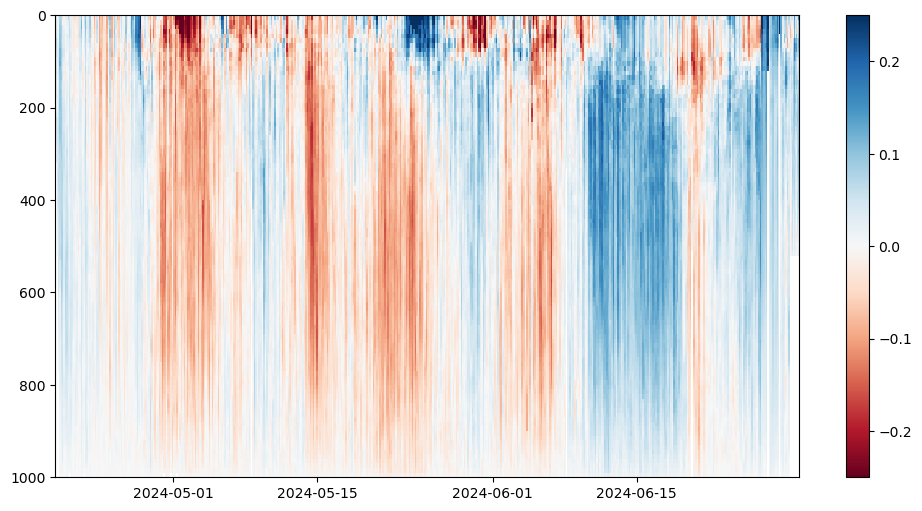

In [9]:
plt.figure(figsize=(12,6))
plt.pcolormesh(ds.time,ds.depth,ds.u_grid,vmin=-0.25,vmax=0.25,cmap='RdBu')
plt.ylim(1000,0)
plt.colorbar()

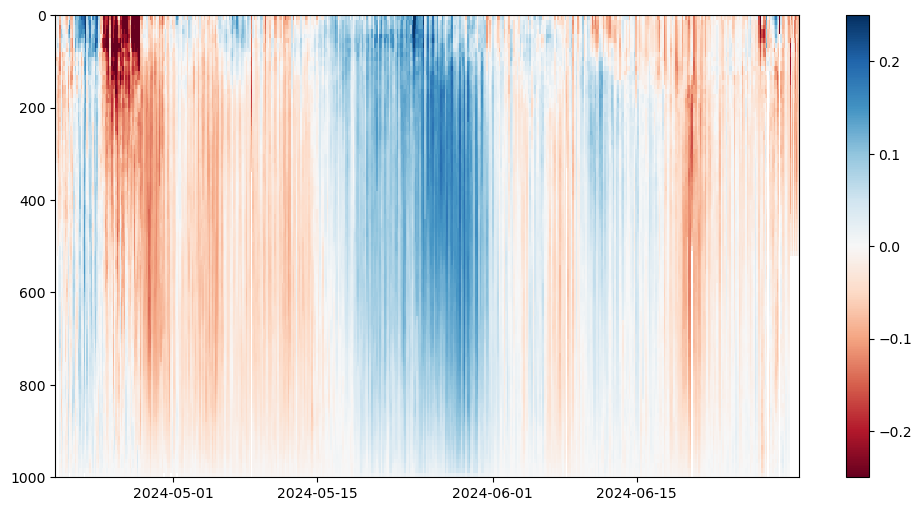

In [10]:
plt.figure(figsize=(12,6))
plt.pcolormesh(ds.time,ds.depth,ds.v_grid,vmin=-0.25,vmax=0.25,cmap='RdBu')
plt.ylim(1000,0)
plt.colorbar()


## Testing complex velocity variance

In [15]:
# Assuming ds has dimensions ('depth', 'time') for u_grid and v_grid
complex_vel = ds.u_grid + 1j * ds.v_grid  # Element-wise complex velocity

# Compute variance over time for each depth
complex_vel_variance = complex_vel.var(dim="time")


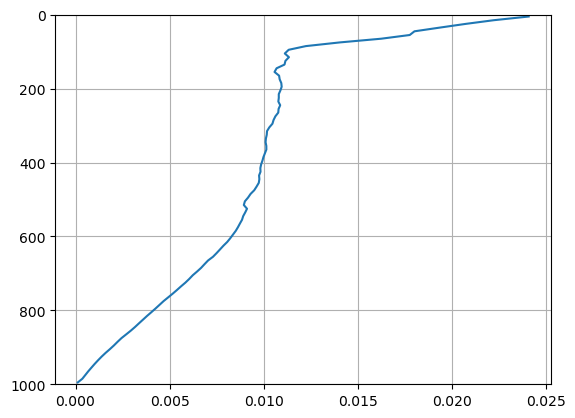

In [14]:
plt.plot(complex_vel_variance,complex_vel_variance.depth)
plt.ylim(1000,0)
plt.grid()